## Supervised model training and evaluation using PCA Dimensionality Reduction

### Topics at Hand:
- Principal Component Analysis (PCA)
- Support Vector Machines (SVM)
- Multi-Layer Perceptron (MLP) Classifier

In [8]:
"""
!pip install scipy
!pip install scikit-learn
!pip install seaborn
"""

In [9]:
import os
import numpy as np
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

session_labels = {
    "1": [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3],
    "2": [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1],
    "3": [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0],
}

# Can customize feature_types:
# de_LDS, de_movingAve, psd_LDS, psd_movingAve 
# de: Differential Entropy (feature-type) 
# psd: Power Spectral Density (feature-type)
# lds: Linear Dynamic System (smoothing)
# movingAve: Moving Average (smoothing)

def extract_features(base_dir, feature_types=["de_LDS"]):
    print("Extracted", feature_types)
    trial_features = []
    trial_labels = []

    for session in ["1", "2", "3"]:
        session_dir = os.path.join(base_dir, session)
        label_list = session_labels[session]
        files = sorted(os.listdir(session_dir))  # 15 subject files

        for file in files:
            mat = loadmat(os.path.join(session_dir, file))

            # Collect all matching trial keys (e.g., de_LDS1, psd_LDS1, etc.)
            trial_dict = {}
            for key in mat:
                for ftype in feature_types:
                    if key.startswith(ftype):
                        trial_idx = int(key[len(ftype):]) - 1
                        if trial_idx not in trial_dict:
                            trial_dict[trial_idx] = {}
                        trial_dict[trial_idx][ftype] = mat[key]

            # Loop through each trial (merged across feature types)
            for trial_idx, feature_map in trial_dict.items():
                all_exist = all(ftype in feature_map for ftype in feature_types)
                if not all_exist:
                    continue  # skip if any feature type is missing

                W = feature_map[feature_types[0]].shape[1]  # number of windows
                trial_windows = []
                for w in range(W):
                    # Concatenate features across feature types
                    window_feature = np.concatenate([
                        feature_map[ftype][:, w, :].flatten()
                        for ftype in feature_types
                    ])
                    trial_windows.append(window_feature)

                trial_features.append(trial_windows)
                trial_labels.append(label_list[trial_idx])

    return trial_features, trial_labels

def plot_confusion(y_true, y_pred, title="Confusion Matrix", labels=None, normalize=True):
    """
    Plots a (normalized) confusion matrix with optional class labels.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        title:  Title for the plot
        labels: List of class names (optional)
        normalize: If True, normalize confusion matrix by row (default: True)
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='viridis', colorbar=True, values_format=".2f" if normalize else "d")
    plt.title(title + (" (Normalized)" if normalize else ""))
    plt.show()

### Load Data

In [10]:
from sklearn.model_selection import train_test_split
# "psd_LDS" + "psd_movingAve"
X_trials, y_trials = extract_features("eeg_feature_smooth", feature_types=["de_LDS"])

# Split Test and Training Set
X_train_trials, X_test_trials, y_train_trials, y_test_trials = train_test_split(
    X_trials, y_trials, test_size=0.2, stratify=y_trials, random_state=42
)

# Flatten
X_train = np.vstack(X_train_trials)
y_train = np.hstack([[label] * len(trial) for trial, label in zip(X_train_trials, y_train_trials)])

X_test = np.vstack(X_test_trials)
y_test = np.hstack([[label] * len(trial) for trial, label in zip(X_test_trials, y_test_trials)])

Extracted ['de_LDS']


### SVM without PCA

In [11]:
# Normalize and Train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

"""
# do SVM
clf = SVC(kernel='rbf', C=1, gamma='scale')
clf.fit(X_train_scaled, y_train)

print("SVM without PCA. 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, clf.predict(X_test_scaled)))

y_pred = clf.predict(X_test_scaled)
plot_confusion(y_test, y_pred, title="SVM (No PCA)", labels=["neutral", "sad", "fear", "happy"])
"""

'\n# do SVM\nclf = SVC(kernel=\'rbf\', C=1, gamma=\'scale\')\nclf.fit(X_train_scaled, y_train)\n\nprint("SVM without PCA. 0=neutral, 1=sad, 2=fear, 3=happy")\nprint(classification_report(y_test, clf.predict(X_test_scaled)))\n\ny_pred = clf.predict(X_test_scaled)\nplot_confusion(y_test, y_pred, title="SVM (No PCA)", labels=["neutral", "sad", "fear", "happy"])\n'

### PCA Reduction

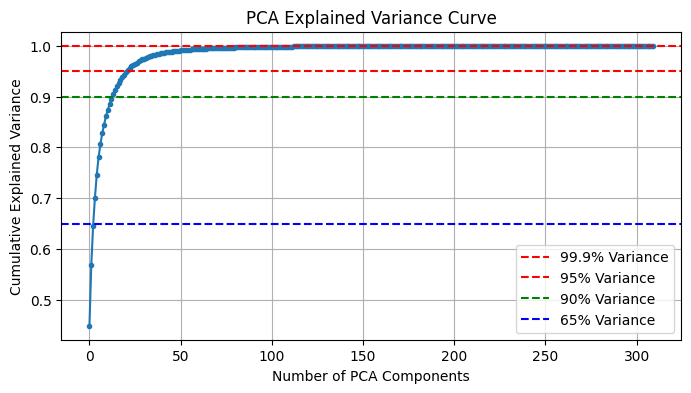

In [12]:
# Plot Variance Explained
pca_full = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o', markersize=3)
plt.axhline(y=0.999, color='r', linestyle='--', label='99.9% Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.axhline(y=0.65, color='b', linestyle='--', label='65% Variance')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
pca = PCA(n_components=0.999)  # Automatically Chosen based on Variance Explained Threshhold
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature dimension: {X_train_scaled.shape[1]}")
print(f"Reduced feature dimension with PCA: {X_train_pca.shape[1]}")
print(f"Number of components used: {pca.n_components_}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

Original feature dimension: 310
Reduced feature dimension with PCA: 133
Number of components used: 133
Explained variance ratio: 0.9990


### SVM with PCA


SVM with PCA. 0=neutral, 1=sad, 2=fear, 3=happy
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2034
           1       0.55      0.49      0.52      2073
           2       0.63      0.57      0.60      1815
           3       0.73      0.66      0.69      1669

    accuracy                           0.64      7591
   macro avg       0.64      0.64      0.64      7591
weighted avg       0.64      0.64      0.64      7591



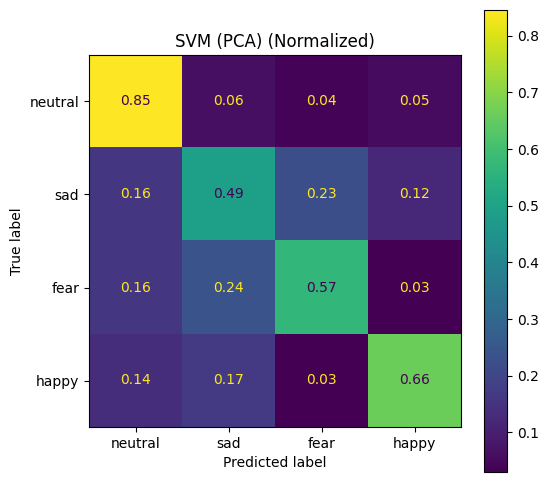

In [7]:
# Train SVM on the PCA-transformed data
clf_pca = SVC(kernel='rbf', C=1, gamma='scale')
clf_pca.fit(X_train_pca, y_train)

# Evaluate the model
y_pred_pca = clf_pca.predict(X_test_pca)
print("\nSVM with PCA. 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, y_pred_pca))
plot_confusion(y_test, y_pred_pca, title="SVM (PCA)", labels=["neutral", "sad", "fear", "happy"])

### MLP Without PCA

In [8]:
"""
# Define and train the MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Evaluate
y_pred_mlp = mlp.predict(X_test_scaled)
print("\nMLP without PCA. 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, y_pred_mlp))
plot_confusion(y_test, y_pred_mlp, title="MLP (No PCA)", labels=["neutral", "sad", "fear", "happy"])
"""

'\n# Define and train the MLP\nmlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)\nmlp.fit(X_train_scaled, y_train)\n\n# Evaluate\ny_pred_mlp = mlp.predict(X_test_scaled)\nprint("\nMLP without PCA. 0=neutral, 1=sad, 2=fear, 3=happy")\nprint(classification_report(y_test, y_pred_mlp))\nplot_confusion(y_test, y_pred_mlp, title="MLP (No PCA)", labels=["neutral", "sad", "fear", "happy"])\n'

### MLP With PCA


MLP with PCA. 0=neutral, 1=sad, 2=fear, 3=happy
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      2034
           1       0.66      0.52      0.58      2073
           2       0.68      0.70      0.69      1815
           3       0.73      0.68      0.70      1669

    accuracy                           0.69      7591
   macro avg       0.69      0.69      0.69      7591
weighted avg       0.69      0.69      0.69      7591



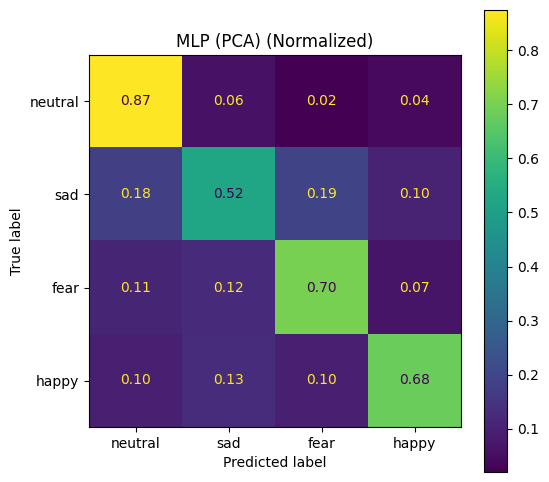

In [9]:
# Train MLP on PCA-reduced data
mlp_pca = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_mlp_pca = mlp_pca.predict(X_test_pca)
print("\nMLP with PCA. 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, y_pred_mlp_pca))
plot_confusion(y_test, y_pred_mlp_pca, title="MLP (PCA)", labels=["neutral", "sad", "fear", "happy"])

### SVM with PCA and Hyperparameter Optimization

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.6860316360092432

SVM with PCA (Best Params). 0=neutral, 1=sad, 2=fear, 3=happy
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      2034
           1       0.62      0.52      0.57      2073
           2       0.64      0.58      0.61      1815
           3       0.72      0.65      0.68      1669

    accuracy                           0.66      7591
   macro avg       0.66      0.66      0.65      7591
weighted avg       0.66      0.66      0.65      7591



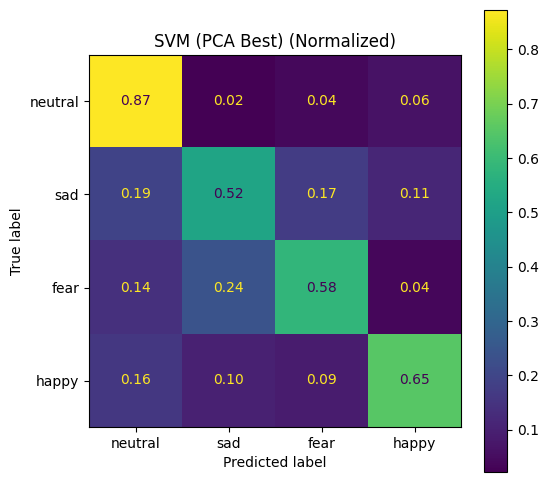

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Set up GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, scoring='accuracy', verbose=1)

# Fit on the PCA-transformed training data
grid.fit(X_train_pca, y_train)

# Show best parameters and accuracy
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Evaluate on test set using best estimator
best_clf = grid.best_estimator_
y_pred_pca = best_clf.predict(X_test_pca)

print("\nSVM with PCA (Best Params). 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, y_pred_pca))
plot_confusion(y_test, y_pred_pca, title="SVM (PCA Best)", labels=["neutral", "sad", "fear", "happy"])

### MLP with PCA and Hyperparameter Optimization

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best MLP parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'solver': 'adam'}

MLP with PCA (Best Params). 0=neutral, 1=sad, 2=fear, 3=happy
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      2034
           1       0.61      0.53      0.57      2073
           2       0.65      0.62      0.63      1815
           3       0.66      0.61      0.63      1669

    accuracy                           0.64      7591
   macro avg       0.64      0.64      0.64      7591
weighted avg       0.64      0.64      0.64      7591



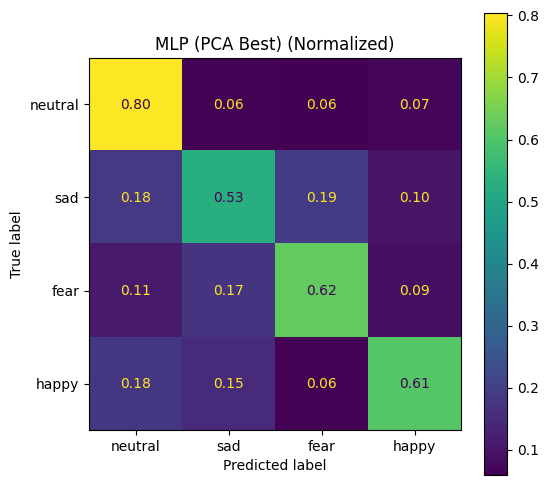

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50), (150, 75)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'solver': ['adam']
}

# Setup grid search with 5-fold cross-validation
grid = GridSearchCV(MLPClassifier(max_iter=500, random_state=42),
                    param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit to PCA-transformed training data
grid.fit(X_train_pca, y_train)

# Use the best model to predict and evaluate
best_mlp = grid.best_estimator_
y_pred_mlp_pca = best_mlp.predict(X_test_pca)

# Results
print("Best MLP parameters:", grid.best_params_)
print("\nMLP with PCA (Best Params). 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, y_pred_mlp_pca))
plot_confusion(y_test, y_pred_mlp_pca, title="MLP (PCA Best)", labels=["neutral", "sad", "fear", "happy"])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Scale your raw data (IMPORTANT for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Narrowed-down parameter grid (safer ranges)
param_grid = {
    'C': [0.01, 0.1, 1],
    'gamma': [0.1, 'scale'],
    'kernel': ['rbf']
}

# Set up GridSearchCV on scaled data
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_scaled, y_train)

# Best estimator evaluation
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test_scaled)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)
print("Train accuracy:", best_clf.score(X_train_scaled, y_train))
print("Test accuracy:", best_clf.score(X_test_scaled, y_test))

print("\nSVM without PCA. 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred, title="SVM (No PCA)", labels=["neutral", "sad", "fear", "happy"])


Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (75,), (100,), (100, 50)],
    'activation': ['relu'],
    'alpha': [0.001, 0.01, 0.1],  # Stronger regularization
    'learning_rate_init': [0.001],
    'solver': ['adam'],
}

# Setup grid search with 5-fold cross-validation
grid = GridSearchCV(MLPClassifier(MLPClassifier(max_iter=1000, early_stopping=True, random_state=42),
                    param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit to PCA-transformed training data
grid.fit(X_train_pca, y_train)

# Use the best model to predict and evaluate
best_mlp = grid.best_estimator_
y_pred_mlp_pca = best_mlp.predict(X_test_pca)

# Results
print("Best MLP parameters:", grid.best_params_)
print("\nMLP with PCA (Best Params). 0=neutral, 1=sad, 2=fear, 3=happy")
print(classification_report(y_test, y_pred_mlp_pca))
plot_confusion(y_test, y_pred_mlp_pca, title="MLP (PCA Best)", labels=["neutral", "sad", "fear", "happy"])